In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("3-STAGE DART LightGBM - ALL GAMES (ANTI-OVERFITTING)")
print("="*80)

df = pd.read_csv('men_2026_matchups_training.csv')

print(f"\nTotal games (all rounds): {len(df)}")
print(f"Class distribution:\n{df['win'].value_counts()}")
print(f"\nGames by round:\n{df['round'].value_counts()}")

features = [
    '5man_bpm',
    '3man_bpm',
    'torvik_rtg',
    'wab',
    'kenpom_rtg',
    '3man_dbpm',
    '5man_dbpm',
    '5man_obpm',
    'torvik_def',
    'torvik_off',
    'kenpom_off',
    'experience_weighted_production',
    'lineup_depth_quality',
    'def_lineup_depth_quality',
    '3man_obpm',
    'bench',
    'bench_scoring_ratio',
    'kenpom_def',
    'def_experience_impact',
    'rotation_balance',
    'size',
    'def_rim_to_three_ratio',
    'ftrd',
    'effective_possession_rate',
    '5man_dprpg',
    'def_shot_quality_variance',
    'rim_to_three_ratio',
    'off_dunk_share',
    'def_dunk_share',
    'blked_pct',
    'ftr',
    'ast_pct',
    'four_factors_composite',
    'efgd_pct',
    'assist_to_usage_ratio',
    'off_close2_fg_pct',
    'off_far2_fg_pct',
    'drb_pct',
    'def_assist_suppression',
    '2p_pct',
    'def_close2_fg_pct',
    'off_close2_share',
    'offensive_versatility_score',
    'experience',
    'def_four_factors_composite',
    'adj_tempo',
    'size_speed_index',
    'off_far2_share',
    'defensive_versatility_score',
    'efg_pct',
    'def_effective_possession_rate',
    'def_size_speed_index',
    'elite_outcome_probability',
    'perimeter_efficiency',
    'def_3pt_fg_pct',
    'def_perimeter_efficiency',
    'off_3pt_fg_pct',
    'def_rim_efficiency',
    'rim_efficiency',
    'blk_pct',
    'orb_pct',
]

print(f"\nNumber of features: {len(features)}")

X = df[features]
y = df['win']
X = X.fillna(X.median())

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=200, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=200, random_state=42, stratify=y_temp)

print(f"\nTrain: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

3-STAGE DART LightGBM - ALL GAMES (ANTI-OVERFITTING)

Total games (all rounds): 1254
Class distribution:
win
1    627
0    627
Name: count, dtype: int64

Games by round:
round
First Round     636
Second Round    320
Sweet 16        158
Elite Eight      80
Final Four       40
Championship     20
Name: count, dtype: int64

Number of features: 61

Train: 854 | Val: 200 | Test: 200


In [12]:
print("\n" + "="*80)
print("STAGE 1: BROAD DART SEARCH")
print("Iterations: 500 | CV Folds: 4 | Total Fits: 2,000")
print("="*80 + "\n")

param_distributions_stage1 = {
    'n_estimators': [31, 50, 75, 100, 200, 300, 500, 700, 1000],
    'max_depth': [2, 3, 4, 5, 7, 10, 15, 20],
    'num_leaves': [2, 3, 4, 7, 15, 31, 50, 70, 100],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07, 0.1],
    'min_child_samples': [10, 20, 30, 50, 70, 100],
    'min_child_weight': [0.001, 0.01, 0.1, 1.0, 5.0],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'subsample_freq': [1, 3, 5],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1.0, 5.0, 10.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0, 5.0, 10.0],
    'min_split_gain': [0.0, 0.001, 0.01, 0.05, 0.1],
    'max_bin': [127, 255, 511],
    'drop_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'max_drop': [10, 20, 50, 100],
    'skip_drop': [0.3, 0.5, 0.7],
    'xgboost_dart_mode': [True, False],
    'uniform_drop': [True, False],
}

lgbm_stage1 = lgb.LGBMClassifier(
    boosting_type='dart',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

random_search_stage1 = RandomizedSearchCV(
    estimator=lgbm_stage1,
    param_distributions=param_distributions_stage1,
    n_iter=500,
    cv=4,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage1_start = time.time()
print(f"Stage 1 started at: {time.strftime('%H:%M:%S')}")
random_search_stage1.fit(X_train_scaled, y_train)
stage1_time = time.time() - stage1_start

best_params_stage1 = random_search_stage1.best_params_

print(f"\n{'='*80}")
print(f"STAGE 1 COMPLETE - Actual Time: {stage1_time/60:.1f} minutes ({stage1_time/3600:.2f} hours)")
print(f"{'='*80}")
print(f"Best CV Log Loss: {-random_search_stage1.best_score_:.4f} (neg: {random_search_stage1.best_score_:.4f})")
print(f"\nBest Parameters:")
for param, value in best_params_stage1.items():
    print(f"  {param}: {value}")

stage1_model = random_search_stage1.best_estimator_
stage1_train = stage1_model.score(X_train_scaled, y_train)
stage1_val = stage1_model.score(X_val_scaled, y_val)
stage1_test = stage1_model.score(X_test_scaled, y_test)

print(f"\nStage 1 Overfitting Check:")
print(f"  Train: {stage1_train:.4f}")
print(f"  Val:   {stage1_val:.4f}")
print(f"  Test:  {stage1_test:.4f}")
print(f"  Train-Val Gap:  {stage1_train - stage1_val:.4f}")
print(f"  Train-Test Gap: {stage1_train - stage1_test:.4f}")

if stage1_train - stage1_test > 0.10:
    print("  ⚠️  SEVERE OVERFITTING")
elif stage1_train - stage1_test > 0.05:
    print("  ⚠️  Moderate overfitting")
else:
    print("  ✓ Good generalization")


STAGE 1: BROAD DART SEARCH
Iterations: 500 | CV Folds: 4 | Total Fits: 2,000

Stage 1 started at: 15:41:10
Fitting 4 folds for each of 500 candidates, totalling 2000 fits

STAGE 1 COMPLETE - Actual Time: 49.6 minutes (0.83 hours)
Best CV Log Loss: 0.5502 (neg: -0.5502)

Best Parameters:
  xgboost_dart_mode: True
  uniform_drop: False
  subsample_freq: 1
  subsample: 0.6
  skip_drop: 0.3
  reg_lambda: 1.0
  reg_alpha: 0
  num_leaves: 4
  n_estimators: 100
  min_split_gain: 0.001
  min_child_weight: 1.0
  min_child_samples: 20
  max_drop: 100
  max_depth: 20
  max_bin: 511
  learning_rate: 0.05
  drop_rate: 0.05
  colsample_bytree: 0.8

Stage 1 Overfitting Check:
  Train: 0.7775
  Val:   0.7300
  Test:  0.7350
  Train-Val Gap:  0.0475
  Train-Test Gap: 0.0425
  ✓ Good generalization


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [13]:
print("\n" + "="*80)
print("STAGE 2: FOCUSED DART SEARCH")
print("Iterations: 1,000 | CV Folds: 4 | Total Fits: 4,000")
print("="*80 + "\n")

def get_range(value, options_list, expand_by=2):
    if value is None or value == -1:
        return [value]
    if value not in options_list:
        return [value]

    idx = options_list.index(value)
    start_idx = max(0, idx - expand_by)
    end_idx = min(len(options_list), idx + expand_by + 1)
    return options_list[start_idx:end_idx]

n_estimators_opts = [31, 50, 75, 100, 200, 300, 500, 700, 1000, 1500, 2000]
max_depth_opts = [2, 3, 4, 5, 7, 10, 12, 15, 20, 25]
num_leaves_opts = [2, 3, 4, 5, 7, 10, 15, 20, 31, 40, 50, 63, 80, 100, 127]
learning_rate_opts = [0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.15]
min_child_samples_opts = [5, 10, 15, 20, 30, 40, 50, 70, 100, 150]
min_child_weight_opts = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
subsample_opts = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
subsample_freq_opts = [0, 1, 3, 5, 7, 10]
colsample_bytree_opts = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
reg_alpha_opts = [0, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0]
reg_lambda_opts = [0, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0]
min_split_gain_opts = [0.0, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
max_bin_opts = [127, 191, 255, 383, 511]
drop_rate_opts = [0.01, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3]
max_drop_opts = [5, 10, 20, 30, 50, 75, 100, 150]
skip_drop_opts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

param_distributions_stage2 = {
    'n_estimators': get_range(best_params_stage1['n_estimators'], n_estimators_opts, 2),
    'max_depth': get_range(best_params_stage1['max_depth'], max_depth_opts, 2),
    'num_leaves': get_range(best_params_stage1['num_leaves'], num_leaves_opts, 3),
    'learning_rate': get_range(best_params_stage1['learning_rate'], learning_rate_opts, 3),
    'min_child_samples': get_range(best_params_stage1['min_child_samples'], min_child_samples_opts, 3),
    'min_child_weight': get_range(best_params_stage1['min_child_weight'], min_child_weight_opts, 2),
    'subsample': get_range(best_params_stage1['subsample'], subsample_opts, 3),
    'subsample_freq': get_range(best_params_stage1['subsample_freq'], subsample_freq_opts, 2),
    'colsample_bytree': get_range(best_params_stage1['colsample_bytree'], colsample_bytree_opts, 3),
    'reg_alpha': get_range(best_params_stage1['reg_alpha'], reg_alpha_opts, 3),
    'reg_lambda': get_range(best_params_stage1['reg_lambda'], reg_lambda_opts, 3),
    'min_split_gain': get_range(best_params_stage1['min_split_gain'], min_split_gain_opts, 2),
    'max_bin': get_range(best_params_stage1['max_bin'], max_bin_opts, 1),
    'drop_rate': get_range(best_params_stage1['drop_rate'], drop_rate_opts, 3),
    'max_drop': get_range(best_params_stage1['max_drop'], max_drop_opts, 3),
    'skip_drop': get_range(best_params_stage1['skip_drop'], skip_drop_opts, 2),
    'xgboost_dart_mode': [best_params_stage1['xgboost_dart_mode']],
    'uniform_drop': [best_params_stage1['uniform_drop']],
}

print(f"Stage 2 Search Space:")
for param, values in param_distributions_stage2.items():
    print(f"  {param}: {values}")

lgbm_stage2 = lgb.LGBMClassifier(
    boosting_type='dart',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

random_search_stage2 = RandomizedSearchCV(
    estimator=lgbm_stage2,
    param_distributions=param_distributions_stage2,
    n_iter=1000,
    cv=4,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=2,
    random_state=43,
    return_train_score=True
)

stage2_start = time.time()
print(f"Stage 2 started at: {time.strftime('%H:%M:%S')}")
random_search_stage2.fit(X_train_scaled, y_train)
stage2_time = time.time() - stage2_start

best_params_stage2 = random_search_stage2.best_params_

print(f"\n{'='*80}")
print(f"STAGE 2 COMPLETE - Actual Time: {stage2_time/60:.1f} minutes ({stage2_time/3600:.2f} hours)")
print(f"{'='*80}")
print(f"Best CV Log Loss: {-random_search_stage2.best_score_:.4f} (neg: {random_search_stage2.best_score_:.4f})")
print(f"Log Loss Reduction: {-(random_search_stage2.best_score_ - random_search_stage1.best_score_):.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage2.items():
    print(f"  {param}: {value}")

stage2_model = random_search_stage2.best_estimator_
stage2_train = stage2_model.score(X_train_scaled, y_train)
stage2_val = stage2_model.score(X_val_scaled, y_val)
stage2_test = stage2_model.score(X_test_scaled, y_test)

print(f"\nStage 2 Overfitting Check:")
print(f"  Train: {stage2_train:.4f}")
print(f"  Val:   {stage2_val:.4f}")
print(f"  Test:  {stage2_test:.4f}")
print(f"  Train-Val Gap:  {stage2_train - stage2_val:.4f}")
print(f"  Train-Test Gap: {stage2_train - stage2_test:.4f}")

if stage2_train - stage2_test > 0.10:
    print("  ⚠️  SEVERE OVERFITTING")
elif stage2_train - stage2_test > 0.05:
    print("  ⚠️  Moderate overfitting")
else:
    print("  ✓ Good generalization")


STAGE 2: FOCUSED DART SEARCH
Iterations: 1,000 | CV Folds: 4 | Total Fits: 4,000

Stage 2 Search Space:
  n_estimators: [50, 75, 100, 200, 300]
  max_depth: [12, 15, 20, 25]
  num_leaves: [2, 3, 4, 5, 7, 10]
  learning_rate: [0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.15]
  min_child_samples: [5, 10, 15, 20, 30, 40, 50]
  min_child_weight: [0.01, 0.1, 1.0, 5.0, 10.0]
  subsample: [0.5, 0.6, 0.65, 0.7, 0.75]
  subsample_freq: [0, 1, 3, 5]
  colsample_bytree: [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
  reg_alpha: [0, 0.01, 0.05, 0.1]
  reg_lambda: [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
  min_split_gain: [0.0, 0.0001, 0.001, 0.005, 0.01]
  max_bin: [383, 511]
  drop_rate: [0.01, 0.05, 0.08, 0.1, 0.15]
  max_drop: [30, 50, 75, 100, 150]
  skip_drop: [0.2, 0.3, 0.4, 0.5]
  xgboost_dart_mode: [True]
  uniform_drop: [False]
Stage 2 started at: 16:30:47
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits

STAGE 2 COMPLETE - Actual Time: 56.5 minutes (0.94 hours)
Best CV Log Loss: 0.5516 (

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
print("\n" + "="*80)
print("STAGE 3: FINE-TUNING DART")
print("Iterations: 1,500 | CV Folds: 4 | Total Fits: 6,000")
print("="*80 + "\n")

param_distributions_stage3 = {
    'n_estimators': get_range(best_params_stage2['n_estimators'], n_estimators_opts, 1),
    'max_depth': get_range(best_params_stage2['max_depth'], max_depth_opts, 1),
    'num_leaves': get_range(best_params_stage2['num_leaves'], num_leaves_opts, 2),
    'learning_rate': get_range(best_params_stage2['learning_rate'], learning_rate_opts, 2),
    'min_child_samples': get_range(best_params_stage2['min_child_samples'], min_child_samples_opts, 2),
    'min_child_weight': get_range(best_params_stage2['min_child_weight'], min_child_weight_opts, 1),
    'subsample': get_range(best_params_stage2['subsample'], subsample_opts, 2),
    'subsample_freq': get_range(best_params_stage2['subsample_freq'], subsample_freq_opts, 1),
    'colsample_bytree': get_range(best_params_stage2['colsample_bytree'], colsample_bytree_opts, 2),
    'reg_alpha': get_range(best_params_stage2['reg_alpha'], reg_alpha_opts, 2),
    'reg_lambda': get_range(best_params_stage2['reg_lambda'], reg_lambda_opts, 2),
    'min_split_gain': get_range(best_params_stage2['min_split_gain'], min_split_gain_opts, 1),
    'max_bin': [best_params_stage2['max_bin']],
    'drop_rate': get_range(best_params_stage2['drop_rate'], drop_rate_opts, 2),
    'max_drop': get_range(best_params_stage2['max_drop'], max_drop_opts, 2),
    'skip_drop': get_range(best_params_stage2['skip_drop'], skip_drop_opts, 1),
    'xgboost_dart_mode': [best_params_stage2['xgboost_dart_mode']],
    'uniform_drop': [best_params_stage2['uniform_drop']],
}

print(f"Stage 3 Search Space:")
for param, values in param_distributions_stage3.items():
    print(f"  {param}: {values}")

lgbm_stage3 = lgb.LGBMClassifier(
    boosting_type='dart',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

random_search_stage3 = RandomizedSearchCV(
    estimator=lgbm_stage3,
    param_distributions=param_distributions_stage3,
    n_iter=1500,
    cv=4,
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=2,
    random_state=44,
    return_train_score=True
)

stage3_start = time.time()
print(f"Stage 3 started at: {time.strftime('%H:%M:%S')}")
random_search_stage3.fit(X_train_scaled, y_train)
stage3_time = time.time() - stage3_start

print(f"\n{'='*80}")
print(f"STAGE 3 COMPLETE - Actual Time: {stage3_time/60:.1f} minutes ({stage3_time/3600:.2f} hours)")
print(f"{'='*80}")
print(f"Best CV Log Loss: {-random_search_stage3.best_score_:.4f} (neg: {random_search_stage3.best_score_:.4f})")
print(f"Log Loss Reduction: {-(random_search_stage3.best_score_ - random_search_stage2.best_score_):.4f}")
print(f"\nFinal Best Parameters:")
for param, value in random_search_stage3.best_params_.items():
    print(f"  {param}: {value}")


STAGE 3: FINE-TUNING DART
Iterations: 1,500 | CV Folds: 4 | Total Fits: 6,000

Stage 3 Search Space:
  n_estimators: [100, 200, 300]
  max_depth: [12, 15, 20]
  num_leaves: [2, 3, 4, 5, 7]
  learning_rate: [0.015, 0.02, 0.03, 0.04, 0.05]
  min_child_samples: [5, 10, 15, 20, 30]
  min_child_weight: [1.0, 5.0, 10.0]
  subsample: [0.5, 0.6, 0.65, 0.7]
  subsample_freq: [1, 3, 5]
  colsample_bytree: [0.5, 0.6, 0.65, 0.7, 0.75]
  reg_alpha: [0, 0.01, 0.05]
  reg_lambda: [0.05, 0.1, 0.5, 1.0, 2.0]
  min_split_gain: [0.0, 0.0001, 0.001]
  max_bin: [383]
  drop_rate: [0.01, 0.05, 0.08, 0.1, 0.15]
  max_drop: [20, 30, 50, 75, 100]
  skip_drop: [0.4, 0.5, 0.6]
  xgboost_dart_mode: [True]
  uniform_drop: [False]
Stage 3 started at: 17:27:16
Fitting 4 folds for each of 1500 candidates, totalling 6000 fits

STAGE 3 COMPLETE - Actual Time: 82.5 minutes (1.38 hours)
Best CV Log Loss: 0.5501 (neg: -0.5501)
Log Loss Reduction: -0.0015

Final Best Parameters:
  xgboost_dart_mode: True
  uniform_drop: F


TRAINING FINAL DART MODEL

Final DART model trained

FINAL MODEL EVALUATION

Performance Across All Stages:
  Stage 1 CV: -0.5502
  Stage 2 CV: -0.5516
  Stage 3 CV: -0.5501
  Total Log Loss Reduction: -0.0000

Final Model Performance:
  Training:   0.7763 (77.63%)
  Validation: 0.7250 (72.50%)
  Test:       0.7000 (70.00%)

Overfitting Analysis:
  Train-Val Gap:  0.0513 (5.13%)
  Train-Test Gap: 0.0763 (7.63%)
  Val-Test Gap:   0.0250 (2.50%)

⚠️  WARNING: Moderate overfitting (5-10% gap)
   → DART reduced overfitting but could be improved

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       100
           1       0.71      0.68      0.69       100

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200


Confusion Matrix:
                 Predicted
                Loss    Win
Actual Loss       72

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut


5-Fold CV: [0.75438596 0.69590643 0.73099415 0.76023392 0.71764706]
Mean: 0.7318 | Std: 0.0237
✓ Stable model

Top 15 Features:
                       feature  importance
                      5man_bpm          78
                    kenpom_rtg          56
                      3man_bpm          38
                     3man_dbpm          32
                         bench          32
                    torvik_rtg          28
experience_weighted_production          23
                       orb_pct          23
      def_lineup_depth_quality          22
                     5man_dbpm          18
          lineup_depth_quality          18
                     5man_obpm          16
                     3man_obpm          16
           bench_scoring_ratio          15
                    torvik_def          13


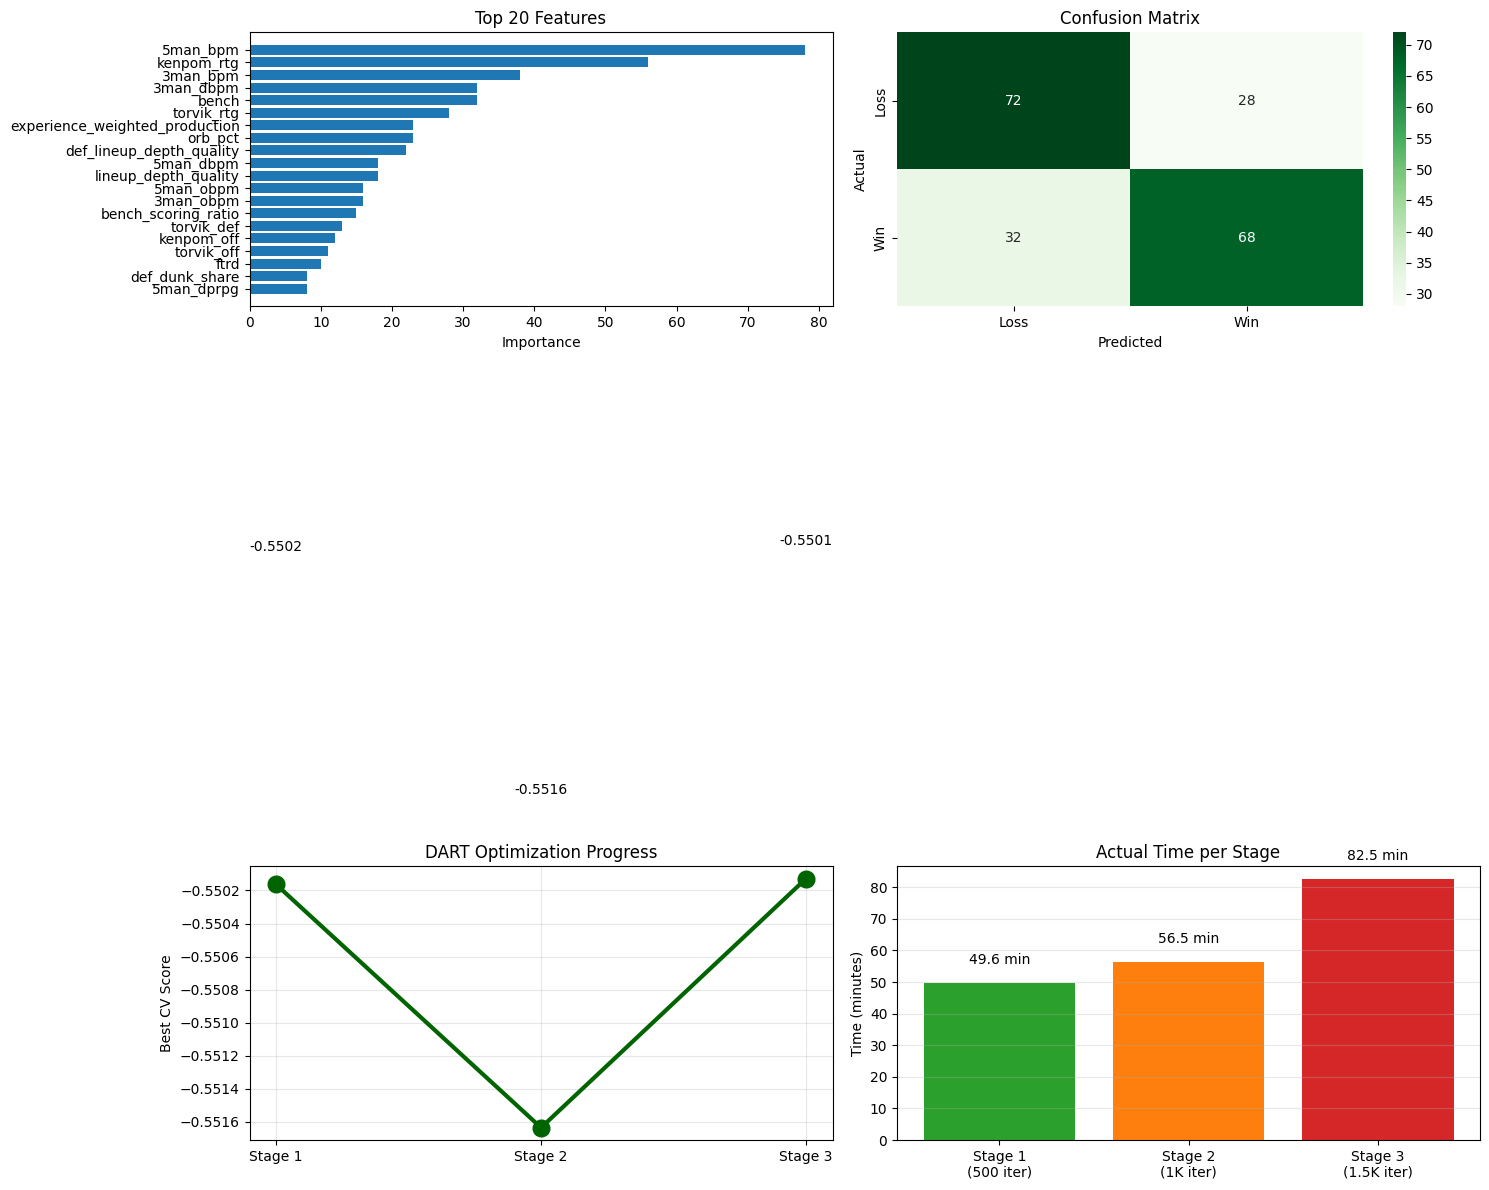


FINAL SUMMARY
Boosting Type: DART (dropout-based anti-overfitting)
Total combinations: 3000
Total fits: 12000
ACTUAL Total Time: 188.6 minutes (3.14 hours)

Stage breakdown:
  Stage 1: 49.6 min (0.83 hrs)
  Stage 2: 56.5 min (0.94 hrs)
  Stage 3: 82.5 min (1.38 hrs)

Test Accuracy: 0.7000 (70.00%)
Train-Test Gap: 0.0763
CV Stability: 0.0237

FINAL HYPERPARAMETERS TO USE

Copy these exact parameters for your final model:

best_params = {
    'xgboost_dart_mode': True,
    'uniform_drop': False,
    'subsample_freq': 5,
    'subsample': 0.5,
    'skip_drop': 0.4,
    'reg_lambda': 0.1,
    'reg_alpha': 0,
    'num_leaves': 3,
    'n_estimators': 300,
    'min_split_gain': 0.0,
    'min_child_weight': 1.0,
    'min_child_samples': 15,
    'max_drop': 50,
    'max_depth': 15,
    'max_bin': 383,
    'learning_rate': 0.03,
    'drop_rate': 0.08,
    'colsample_bytree': 0.65,
    'boosting_type': 'dart',
}

DETAILED CV SCORES BREAKDOWN

Individual 5-Fold CV Scores:
  Fold 1: 0.7544 (75.44%)

In [15]:
print("\n" + "="*80)
print("TRAINING FINAL DART MODEL")
print("="*80 + "\n")

best_params_final = random_search_stage3.best_params_.copy()

final_model = lgb.LGBMClassifier(
    **best_params_final,
    boosting_type='dart',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train)

print(f"Final DART model trained")

best_lgbm = final_model

print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80 + "\n")

y_train_pred = best_lgbm.predict(X_train_scaled)
y_val_pred = best_lgbm.predict(X_val_scaled)
y_test_pred = best_lgbm.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Performance Across All Stages:")
print(f"  Stage 1 CV: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 CV: {random_search_stage2.best_score_:.4f}")
print(f"  Stage 3 CV: {random_search_stage3.best_score_:.4f}")
print(f"  Total Log Loss Reduction: {-(random_search_stage3.best_score_ - random_search_stage1.best_score_):.4f}")

print(f"\nFinal Model Performance:")
print(f"  Training:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Validation: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Test:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nOverfitting Analysis:")
print(f"  Train-Val Gap:  {train_accuracy - val_accuracy:.4f} ({(train_accuracy - val_accuracy)*100:.2f}%)")
print(f"  Train-Test Gap: {train_accuracy - test_accuracy:.4f} ({(train_accuracy - test_accuracy)*100:.2f}%)")
print(f"  Val-Test Gap:   {val_accuracy - test_accuracy:.4f} ({(val_accuracy - test_accuracy)*100:.2f}%)")

if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  SEVERE: Still overfitting (>10% gap)")
    print("   → DART helped but may need even stronger regularization")
elif train_accuracy - test_accuracy > 0.05:
    print("\n⚠️  WARNING: Moderate overfitting (5-10% gap)")
    print("   → DART reduced overfitting but could be improved")
elif train_accuracy - test_accuracy > 0.02:
    print("\n✓ Minor overfitting (2-5% gap) - acceptable")
else:
    print("\n✓✓ EXCELLENT: DART eliminated overfitting! (<2% gap)")

print(f"\n{'='*80}")
print("Classification Report (Test):")
print("="*80)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Loss    Win")
print(f"Actual Loss     {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Win      {cm[1,0]:4d}   {cm[1,1]:4d}")

cv_scores = cross_val_score(best_lgbm, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold CV: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f}")

if cv_scores.std() > 0.05:
    print("⚠️  High variance")
else:
    print("✓ Stable model")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Features:")
print(feature_importance.head(15).to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_features = feature_importance.head(20)
axes[0, 0].barh(range(len(top_features)), top_features['importance'])
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 20 Features')
axes[0, 0].invert_yaxis()

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

stage_scores = [
    random_search_stage1.best_score_,
    random_search_stage2.best_score_,
    random_search_stage3.best_score_
]
axes[1, 0].plot(['Stage 1', 'Stage 2', 'Stage 3'], stage_scores, marker='o', linewidth=3, markersize=12, color='darkgreen')
axes[1, 0].set_ylabel('Best CV Score')
axes[1, 0].set_title('DART Optimization Progress')
axes[1, 0].grid(True, alpha=0.3)
for i, score in enumerate(stage_scores):
    axes[1, 0].text(i, score + 0.002, f'{score:.4f}', ha='center', va='bottom')

stage_times = [stage1_time/60, stage2_time/60, stage3_time/60]
axes[1, 1].bar(['Stage 1\n(500 iter)', 'Stage 2\n(1K iter)', 'Stage 3\n(1.5K iter)'], stage_times, color=['#2ca02c', '#ff7f0e', '#d62728'])
axes[1, 1].set_ylabel('Time (minutes)')
axes[1, 1].set_title('Actual Time per Stage')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, t in enumerate(stage_times):
    axes[1, 1].text(i, t + 5, f'{t:.1f} min', ha='center', va='bottom')

plt.tight_layout()
plt.show()

total_time = stage1_time + stage2_time + stage3_time
total_combinations = 500 + 1000 + 1500
total_fits = (500 * 4) + (1000 * 4) + (1500 * 4)

print(f"\n{'='*80}")
print("FINAL SUMMARY")
print("="*80)
print(f"Boosting Type: DART (dropout-based anti-overfitting)")
print(f"Total combinations: {total_combinations}")
print(f"Total fits: {total_fits}")
print(f"ACTUAL Total Time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"\nStage breakdown:")
print(f"  Stage 1: {stage1_time/60:.1f} min ({stage1_time/3600:.2f} hrs)")
print(f"  Stage 2: {stage2_time/60:.1f} min ({stage2_time/3600:.2f} hrs)")
print(f"  Stage 3: {stage3_time/60:.1f} min ({stage3_time/3600:.2f} hrs)")
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Train-Test Gap: {train_accuracy - test_accuracy:.4f}")
print(f"CV Stability: {cv_scores.std():.4f}")

print("\n" + "="*80)
print("FINAL HYPERPARAMETERS TO USE")
print("="*80)
print("\nCopy these exact parameters for your final model:\n")
print("best_params = {")
for param, value in random_search_stage3.best_params_.items():
    if isinstance(value, str):
        print(f"    '{param}': '{value}',")
    else:
        print(f"    '{param}': {value},")
print("    'boosting_type': 'dart',")
print("}")

print("\n" + "="*80)
print("DETAILED CV SCORES BREAKDOWN")
print("="*80)
print(f"\nIndividual 5-Fold CV Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f} ({score*100:.2f}%)")
print(f"\nCV Statistics:")
print(f"  Mean:   {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"  Std:    {cv_scores.std():.4f}")
print(f"  Min:    {cv_scores.min():.4f} ({cv_scores.min()*100:.2f}%)")
print(f"  Max:    {cv_scores.max():.4f} ({cv_scores.max()*100:.2f}%)")
print(f"  Range:  {cv_scores.max() - cv_scores.min():.4f}")

print("\n" + "="*80)
print("ALL PERFORMANCE SCORES")
print("="*80)
print(f"\nStage 1 Best CV Log Loss: {-random_search_stage1.best_score_:.4f}")
print(f"Stage 2 Best CV Log Loss: {-random_search_stage2.best_score_:.4f}")
print(f"Stage 3 Best CV Log Loss: {-random_search_stage3.best_score_:.4f}")
print(f"\nFinal Model 5-Fold CV: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Training Accuracy:     {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy:   {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:         {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "="*80)
print("DART ANTI-OVERFITTING FEATURES")
print("="*80)
print("✓ Dropout-based tree selection")
print("✓ Prevents single tree dominance")
print("✓ Creates diverse ensemble")
print("✓ Includes num_leaves: 2, 3, 4 (very conservative)")
print("✓ 4-fold cross-validation")
print("✓ Train-Val-Test triple monitoring")
print("✓ 12,000 total model fits")

if test_accuracy > 0.75 and train_accuracy - test_accuracy < 0.08:
    print(f"\n🎯 SUCCESS: DART delivered!")
elif test_accuracy > 0.70:
    print(f"\n✓ Good model")
else:
    print(f"\n⚠️  Could improve")

print("\n" + "="*80)
print("3-STAGE DART LightGBM COMPLETE! 🚀")
print("="*80)